# Understanding the Problem Statement:
The goal is to predict whether a given molecule is active (1) or inactive (0) by using data-driven techniques, specifically binary classification models. In drug discovery, identifying whether a molecule binds to a specific receptor is a crucial step since binding generally indicates the molecule may be a good candidate for a drug.

## Overview and Assignment Goals
The objectives of this assignment are the following: 

* Use/implement a feature selection/reduction technique.
* Experiment with various classification models.
* Think about dealing with imbalanced data.
* Use F1 Scoring Metric

#### The dataset has an imbalanced distribution i.e., within the training set there are only 78 actives (+1) and 722 inactives (0). No information is provided for the test set regarding the distribution.

## Data Description

The training dataset consists of 800 records and the test dataset consists of 350 records. We provide you with the training class labels and the test labels are held out. The attributes are binary type and as such are presented in a sparse matrix format within train.dat and test.dat

**Train data:** Training set (a sparse binary matrix, patterns in lines, features in columns: the index of the non-zero features are provided with class label 1 or 0 in the first column).

**Test data:** Testing set (a sparse binary matrix, patterns in lines, features in columns: the index of non-zero features are provided).

**Format example:** A sample submission with 350 entries randomly chosen to be 0 or 1.

In [7]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import math
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [8]:
# Initialize a list to store the processed data
data = []
with open("train_data.txt", 'r') as file:
    for line in file:
        # Skip empty lines
        if line.strip():
            # Replace any tabs with spaces and remove the trailing newline
            clean_line = re.sub(r'\t+', ' ', line).strip()

            # Extract the label (first character as an integer)
            label = int(clean_line[0])

            # Extract the features (rest of the line as a list of integers)
            features = [int(f) for f in clean_line[2:].strip().split()]

            # Append the label and features as a tuple to the data list 
            data.append((label, features))

In [15]:
max_length = max(len(features) for _, features in data)

# Pad each feature list to the same length with zeros
X = [features + [0] * (max_length - len(features)) for _, features in data]
y = [label for label, _ in data]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_resampled, y_resampled = apply_oversampling(X_train, y_train)

In [18]:
pre_processing_pipeline = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.03)),  # Remove low variance features
    ('svd', TruncatedSVD(n_components=30, random_state=42)),  # Reduce dimensionality
    ('scaler', MaxAbsScaler())  # Scale data to range [0, 1]
])

In [20]:
def apply_oversampling(X, y):
    oversampler = RandomOverSampler(random_state=42)
    return oversampler.fit_resample(X, y)

X_train_resampled, y_train_resampled = apply_oversampling(X_train, y_train)

In [23]:
X_resampled_preprocessed = pre_processing_pipeline.fit_transform(X_train_resampled)

# Transform the original test data using the same pipeline
X_test_preprocessed = pre_processing_pipeline.transform(X_test)

# Step 5: Train Models
clf = DecisionTreeClassifier(random_state=42)
NB = GaussianNB()

# Train the models on the preprocessed training data
clf.fit(X_resampled_preprocessed, y_resampled)
NB.fit(X_resampled_preprocessed, y_resampled)

# Step 6: Predict and Evaluate
y_pred_dt = clf.predict(X_test_preprocessed)
y_pred_nb = NB.predict(X_test_preprocessed)

f1_dt = f1_score(y_test, y_pred_dt)
f1_nb = f1_score(y_test, y_pred_nb)

print(f"F1-Score (Decision Tree): {f1_dt}")
print(f"F1-Score (Naive Bayes): {f1_nb}")

print("\nClassification Report (Decision Tree):")
print(classification_report(y_test, y_pred_dt))

print("\nClassification Report (Naive Bayes):")
print(classification_report(y_test, y_pred_nb))

F1-Score (Decision Tree): 0.08333333333333333
F1-Score (Naive Bayes): 0.14035087719298245

Classification Report (Decision Tree):
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       146
           1       0.10      0.07      0.08        14

    accuracy                           0.86       160
   macro avg       0.51      0.50      0.50       160
weighted avg       0.84      0.86      0.85       160


Classification Report (Naive Bayes):
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       146
           1       0.09      0.29      0.14        14

    accuracy                           0.69       160
   macro avg       0.50      0.51      0.48       160
weighted avg       0.84      0.69      0.75       160



In [16]:
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import classification_report, f1_score
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler, ADASYN
# from imblearn.combine import SMOTETomek

# # Step 1: Train/Test Split


# # Step 2: Resampling Functions
# def apply_undersampling(X, y):
#     undersampler = RandomUnderSampler(random_state=42)
#     return undersampler.fit_resample(X, y)

# def apply_oversampling(X, y):
#     oversampler = RandomOverSampler(random_state=42)
#     return oversampler.fit_resample(X, y)

# def apply_adasyn(X, y):
#     adasyn = ADASYN(random_state=42)
#     return adasyn.fit_resample(X, y)

# def apply_smote_tomek(X, y):
#     smote_tomek = SMOTETomek(random_state=42)
#     return smote_tomek.fit_resample(X, y)

# # Step 3: Function to Train, Predict, and Evaluate F1-Score
# def train_and_evaluate(X_resampled, y_resampled, X_test, y_test):
#     # Scaling the data
#     scaler = StandardScaler()
#     X_resampled_scaled = scaler.fit_transform(X_resampled)
    

#     # Apply PCA (optional)
#     pca = PCA(n_components=10)
#     X_resampled_pca = pca.fit_transform(X_resampled_scaled)
#     X_train, X_test, y_train, y_test = train_test_split(X_resampled_pca, y_resampled, test_size=0.2, random_state=42)
    
#     # Train a Decision Tree with class weights
#     clf = DecisionTreeClassifier(random_state=42)
#     clf.fit(X_train, y_train)
#     NB = GaussianNB()
#     NB.fit(X_train, y_train)

#     # Predict and calculate F1-Score
#     y_pred = clf.predict(X_test)
#     y_pred_NB = NB.predict(X_test)
#     f1 = f1_score(y_test, y_pred)
#     f1_NB = f1_score(y_test, y_pred_NB)

#     # Display F1-Score and classification report
#     print(f"F1-Score (Decision Tree): {f1}")
#     print(f"F1-Score (Naive Bayes): {f1_NB}")
#     #print("Classification Report:")
#     #print(classification_report(y_test, y_pred))
#     return f1, f1_NB, scaler, pca, clf, NB

# # Step 4: Apply All Resampling Techniques and Evaluate
# # print("Using Random Undersampling:")
# # X_resampled, y_resampled = apply_undersampling(X, y)
# # f1_undersampling_decision, f1_undersampling_NB = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

# print("\nUsing Random Oversampling:")
# X_resampled, y_resampled = apply_oversampling(X, y)
# f1_oversampling_DT, f1_oversampling_NB, scaler, pca, clf, NB = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

# print("\nUsing ADASYN:")
# X_resampled, y_resampled = apply_adasyn(X, y)
# f1_adasyn_DT, f1_adasyn_NB = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

# print("\nUsing SMOTE + Tomek Links:")
# X_resampled, y_resampled = apply_smote_tomek(X, y)
# f1_smote_tomek_DT, f1_smote_tomek_NB = train_and_evaluate(X_resampled, y_resampled, X_test, y_test)

# # Step 5: Display All F1-Scores for Comparison
# # print("\nF1-Scores for Different Resampling Techniques:")
# # print(f"Random Undersampling_DT: {f1_undersampling_decision}")
# # print(f"Random Undersampling_NB: {f1_undersampling_NB}")
# # print(f"Random Oversampling_DT: {f1_oversampling_DT}")
# # print(f"Random Oversampling_NB: {f1_oversampling_NB}")
# # print(f"ADASYN_DT: {f1_adasyn_DT}")
# # print(f"ADASYN_NB: {f1_adasyn_NB}")
# # print(f"SMOTE + Tomek Links_DT: {f1_smote_tomek_DT}")
# # print(f"SMOTE + Tomek Links_NB: {f1_smote_tomek_NB}")

### Now lets do the testing 

In [42]:
test_data = []
expected_length = 5524
with open("test_data.txt", 'r') as file:
    for line in file:
        if line.strip():
            clean_line = re.sub(r'\t+', ' ', line).strip()
            ready_data = [int(f) for f in clean_line.split()]
            if len(ready_data) < expected_length:
                    ready_data += [0] * (expected_length - len(ready_data))  # Pad with zeros
            elif len(ready_data) > expected_length:
                    ready_data = ready_data[:expected_length] 
            test_data.append(ready_data)
print(len(test_data))

350


In [43]:
# max_length = max(len(row) for row in test_data)
# test_data_padded = [row + [0] * (max_length - len(row)) for row in test_data]

In [44]:
X_test_unseen_scale = scaler.transform(test_data)  # Use the same scaler from training
X_test_unseen_pca = pca.transform(test_data) 

In [46]:
y_pred_test_dt = clf.predict(X_test_unseen_pca)
y_pred_test_nb = NB.predict(X_test_unseen_pca)

# Display Predictions
print("Predictions (Decision Tree):", y_pred_test_dt)
print("Predictions (Naive Bayes):", y_pred_test_nb)

Predictions (Decision Tree): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
Predictions (Naive Bayes): [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1

In [47]:
format_file = "Format_1.txt"
with open(format_file, 'w+') as file:
    for prediction in y_pred_test_dt:
        file.write(str(prediction) + '\n')


Using RandomOversampling:
Best parameters: {'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
F1-Score (Validation): 0.6923
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       146
           1       0.75      0.64      0.69        14

    accuracy                           0.95       160
   macro avg       0.86      0.81      0.83       160
weighted avg       0.95      0.95      0.95       160

Predictions saved to format_file_RandomOversampling.txt

Using SMOTE:
Best parameters: {'classifier__max_depth': 2, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
F1-Score (Validation): 0.7200
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       146
           1       0.82      0.64      0.72        14

    accuracy                           0.96       160
   macro avg       0.89      0.81      0.85       160
weighted a

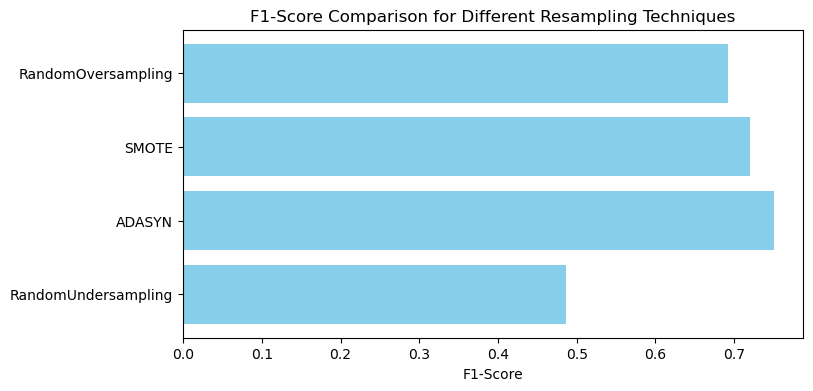

In [5]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline

results = []
# Function to load and process data from TXT files
def load_and_process_data(file_path, is_train=True):
    data = []
    labels = [] if is_train else None

    with open(file_path, 'r') as file:
        for line in file:
            if line.strip():  # Skip empty lines
                parts = line.strip().split()
                if is_train:
                    labels.append(int(parts[0]))  # Extract class label
                    features = list(map(int, parts[1:]))  # Extract feature indices
                else:
                    features = list(map(int, parts))  # Only feature indices for test data
                data.append(features)

    max_index = max(max(features) for features in data)
    binary_array = np.zeros((len(data), max_index + 1), dtype=int)

    for row_idx, indices in enumerate(data):
        binary_array[row_idx, indices] = 1

    csr_feature_matrix = csr_matrix(binary_array)
    if is_train:
        return csr_feature_matrix, np.array(labels)
    else:
        return csr_feature_matrix

# Preprocessing pipeline
pre_processing_pipeline = Pipeline([
    ('var_thresh', VarianceThreshold(threshold=0.03)),
    ('svd', TruncatedSVD(n_components=80, random_state=42)),
    ('scaler', MaxAbsScaler())
])

# List of imbalance handling techniques
resampling_techniques = {
    'RandomOversampling': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'RandomUndersampling': RandomUnderSampler(random_state=42)
}

# Hyperparameter grid for Decision Tree
param_grid = {
    'classifier__max_depth': range(2, 10),
    'classifier__min_samples_leaf': range(1, 6),
    'classifier__min_samples_split': range(2, 6)
}

# Load and preprocess training data
X, y = load_and_process_data('train_data.txt', is_train=True)
X_preprocessed = pre_processing_pipeline.fit_transform(X)

# Train/test split
X_train, X_val, y_train, y_val = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Function to train and predict with different imbalance techniques
def train_and_predict_with_resampling(technique_name, resampler):
    pipeline = Pipeline([
        ('resampler', resampler),
        ('classifier', DecisionTreeClassifier(class_weight='balanced', random_state=42))
    ])
    
    # Hyperparameter tuning using GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_val_pred = best_model.predict(X_val)

    f1 = f1_score(y_val, y_val_pred)
    results.append([technique_name, f1, grid_search.best_params_])

    # Display results
    print(f"\nUsing {technique_name}:")
    print("Best parameters:", grid_search.best_params_)
    print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred):.4f}")
    print(classification_report(y_val, y_val_pred))

    # Load and preprocess the test data
    X_test = load_and_process_data('test_data.txt', is_train=False)
    X_test_preprocessed = pre_processing_pipeline.transform(X_test)

    # Predict on the test data
    test_predictions = best_model.predict(X_test_preprocessed)

    # Save predictions to a TXT file
    output_file = f"format_file_{technique_name}.txt"
    with open(output_file, 'w+') as file:
        for prediction in test_predictions:
            file.write(str(prediction) + '\n')

    print(f"Predictions saved to {output_file}")

# Apply all resampling techniques and predict
for technique_name, resampler in resampling_techniques.items():
    train_and_predict_with_resampling(technique_name, resampler)


df_results = pd.DataFrame(results, columns=['Technique', 'F1-Score', 'Best Parameters'])

# Visualization of F1-scores using a bar chart
plt.figure(figsize=(8, 4))
plt.barh(df_results['Technique'], df_results['F1-Score'], color='skyblue')
plt.xlabel('F1-Score')
plt.title('F1-Score Comparison for Different Resampling Techniques')
plt.gca().invert_yaxis()  # Invert y-axis to show highest score on top
plt.show()
